# Notebook for estimating, which variables of weather data correlate with sun intensity

# Load data from .xlsx file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime


## Solar intensity data

In [2]:
#Load initial data
hourly_sun_intensity = pd.read_excel('2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [3]:
hourly_sun_intensity.head()

,Aasta,Kuu,Päaev,Kell (UTC),"Haapsalu summaarne kiirgus, W/m²","Tallinn-Harku summaarne kiirgus, W/m²","Narva summaarne kiirgus, W/m²","Narva-Jõesuu summaarne kiirgus, W/m²","Pärnu summaarne kiirgus, W/m²","Pärnu-Sauga summaarne kiirgus, W/m²","Roomassaare summaarne kiirgus, W/m²","Tartu-Tõravere summaarne kiirgus, W/m²","Tiirikoja summaarne kiirgus, W/m²","Vilsandi summaarne kiirgus, W/m²"
0,2010,1,1,00:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0
1,2010,1,1,01:00:00,NaN,0,NaN,1.0,NaN,1.0,0.0,0,0.0,0.0
2,2010,1,1,02:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
3,2010,1,1,03:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
4,2010,1,1,04:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0


In [4]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"
for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
#newColumnNames = ["y", "m", "d", "time"]+["solar_"+columnName.replace(" summaarne kiirgus, W/m²", "") for columnName in hourly_sun_intensity.columns if "kiirgus" in columnName]
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)
#hourly_sun_intensity.columns = newColumnNames

In [5]:
hourly_sun_intensity.head()

,y,m,d,time,solar_Haapsalu,solar_Tallinn-Harku,solar_Narva,solar_Narva-Jõesuu,solar_Pärnu,solar_Pärnu-Sauga,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi
0,2010,1,1,00:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0
1,2010,1,1,01:00:00,NaN,0,NaN,1.0,NaN,1.0,0.0,0,0.0,0.0
2,2010,1,1,02:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
3,2010,1,1,03:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
4,2010,1,1,04:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0


In [6]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [7]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [8]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

In [9]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.datetime.combine(datetime.date(row.y, row.m, row.d), row.time)+datetime.timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [10]:
hourly_sun_intensity_Shifted = shiftDateTime(hourly_sun_intensity, -1)

## Data from different weather stations

In [11]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", "Õhutemperatuur °C", "10 minuti keskmine tuule kiirus m/s", "Õhurõhk jaama kõrgusel hPa", "Suhteline õhuniiskus %", "10 minuti keskmine tuule suund"]

In [12]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [13]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [14]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, 'Tallinn-Harku')
#Get Roomassaare
data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, 'Roomassaare')
#Merge tables
data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

In [15]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "Vilsandi")
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [16]:
#Get Tartu
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, 'Tartu-Tõravere')
#Merge tables
data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])

In [17]:
#Get Tiirikoja
data_Tiirikoja = getFromXlsx("./data/Tiirikoja_2004-2020.xlsx", selectedColumns, "Tiirikoja")
data_weather = data_weather.merge(data_Tiirikoja, how='left', on=["y", "m", "d", "time"])

In [18]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

## Merge two tables


In [19]:
data_solar_weather = data_weather.merge(hourly_sun_intensity, how='left', on=["y", "m", "d", "time"])

## Create dataframe where the location is not important

In [20]:
weatherStations = ['Tallinn-Harku', 'Roomassaare', "Vilsandi", 'Tartu-Tõravere', "Tiirikoja"]

In [21]:
data_solar_weather_noLocation = pd.DataFrame()

for weatherStation in weatherStations:
    #Select right columns
    data_solar_weather_location = data_solar_weather[['y', 'm', 'd', 'time', f'temp_{weatherStation}', f'wind_speed_{weatherStation}',
       f'pressure_{weatherStation}', f'rel_humidity_{weatherStation}', f'solar_{weatherStation}']]
    columnNames = dict()
    for i in range(len(data_solar_weather_location.columns)):
        columnNames[data_solar_weather_location.columns[i]] = data_solar_weather_location.columns[i].replace(f"_{weatherStation}", "")
    data_solar_weather_location = data_solar_weather_location.rename(columns=columnNames)
    
    data_solar_weather_noLocation = data_solar_weather_noLocation.append(data_solar_weather_location)

In [22]:
data_solar_weather_noLocation = data_solar_weather_noLocation.dropna()

## Check, which variables correlate with solar intensity

/home/main/anaconda3/envs/metsat/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
/home/main/anaconda3/envs/metsat/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


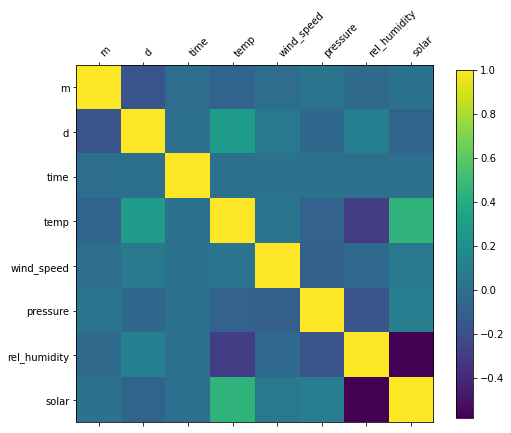

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(data_solar_weather_noLocation.corr())
ax.set_xticklabels(data_solar_weather_noLocation.columns, rotation = 45, ha="left")
ax.set_yticklabels(data_solar_weather_noLocation.columns)
#ax.set_xticks(np.arange(0,8,1))
#ax.set_yticks(np.arange(0,8,1))
#ax.set_ylim(bottom=8.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()

<AxesSubplot:>

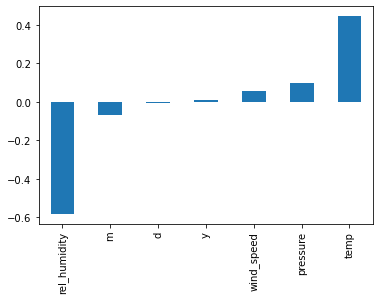

In [24]:

data_solar_weather_noLocation.corr().loc['solar'].drop(['solar']).sort_values().plot.bar()